# Problem 3: Digital divide

I worked on this problem set with Kevin Song.

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter
from PIL import Image

spark = SparkSession.builder.appName('mnist').getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')

## Part 1: learning to plot and getting the feel for MNIST

In [ ]:
#df.show()

In [89]:
#extract a subset of features
all_data = df.rdd.map(lambda x: (np.array(x['features']),int(x[1])))
subset = all_data.sample(False,float(50000)/float(70000),seed=123)

In [91]:
x = all_data.count()
print 'features: ', x

y = subset.count()
print 'subset: ', y

features:  70000
subset:  50135


In [92]:
#collect the subset labels and arrays
subset_labels = subset.map(lambda x: x[1]).collect()
subset_features = subset.map(lambda x: x[0]).collect()

In [ ]:
#print subset_labels

/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


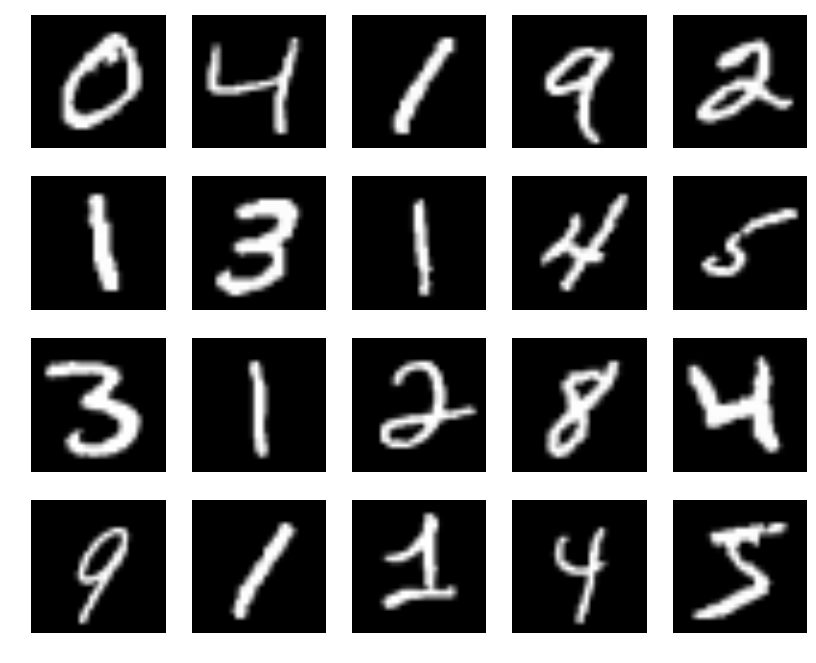

In [93]:
#plot subset of data
nrows = 4
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
subset_to_test_plt = subset.map(lambda x: x[0]).take(20)
for i in np.arange(20): #xrange(nrows*ncols):
    if i < (ncols * ncols - 4): # & i < ncols*nrows:
        #print i
        plt.subplot(nrows, ncols, i)
        plt.imshow(subset_to_test_plt[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
        
plt.axis('off')
plt.show()

# Part 1: PCA

## 1(a): extract principal components

After you have read in the training data, you will have to standardize the data, which means subtracting the mean and dividing by the standard deviation. Then, perform PCA to extract the principal components of the standardized training data. You may not use a library to do PCA for you, but you may use libraries (for example from numpy) to compute the singular value or eigenvalue decomposition of a matrix. Display the first 10 principal components as images. If you wish, you can then use the builtin PCA function in pyspark.mllib to compare to your results.

In [94]:
df = spark.read.json('/project/cmsc25025/mnist/data.json')
all_data = df.rdd.map(lambda x: (np.array(x['features']),int(x[1])))

#standardize first
all_data_features = all_data.map(lambda x: x[0])

In [95]:
N = all_data_features.count()
print N

70000


In [96]:
#mean
mu = all_data_features.reduce(lambda a,b: a+b)/N
#print mu

In [97]:
#stdev
sigma = all_data_features.map(lambda x: (x-mu)**2).reduce(lambda a,b: a+b)/(N**2)
sigma = np.sqrt(sigma)
#print sigma

In [98]:
#wary of NaNs due to black borders, convert NaNs to 0
std_data_features = all_data_features.map(lambda x: np.nan_to_num((x-mu)/sigma))

#construct covariance matrix as the sum of outer products
#(ref.: http://www.math.uah.edu/stat/expect/Matrices.html)
std_data_features = std_data_features.map(lambda x: np.outer(x,x)/N).reduce(lambda a,b: a+b)

In [99]:
#do SVD to get principal components
eVals, eVecs = np.linalg.eigh(std_data_features)

#sort evals in descending order and get corresponding evecs
ix = eVals.argsort()[::-1] #reverse vector to get largest eVals
eVals = eVals[ix]
eVecs = eVecs[:,ix] #principal vectors are in columns

#get top 10 PCs
top_eVals = eVals[0:10]
top_eVecs = eVecs[:,0:10]


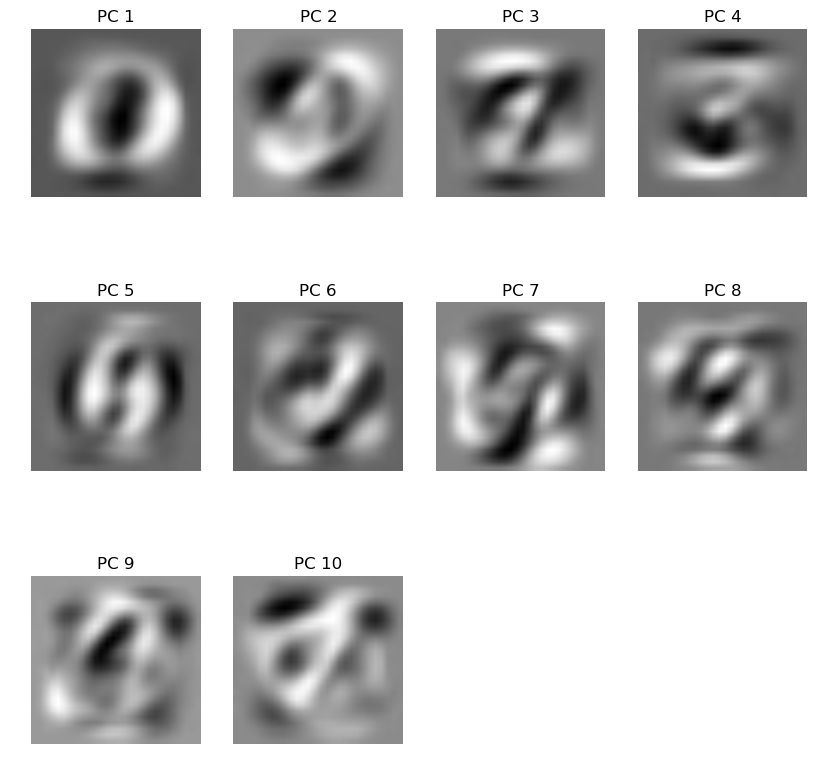

In [100]:
#plot principal vectors
plt.figure(figsize=(10,10))
for i in np.arange(10):
    plt.subplot(3,4,i+1)
    plt.imshow((top_eVecs[:,i]).reshape((28,28)), cmap='gray')
    plt.axis('off')
    plt.title('PC %d' %(i+1))
plt.axis('off')
plt.show()

## 1(b): Plot variance. 
Plot the variance of all of the principal components—this corresponds to the singular
values. This should be monotonically decreasing.

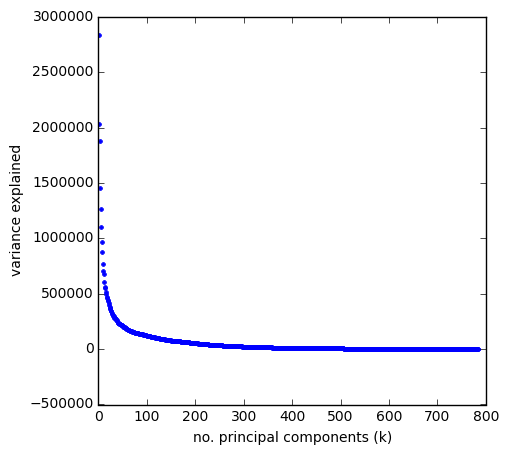

In [101]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(len(eVals))+1,eVals,'.')
plt.xlabel('no. principal components (k)')
plt.ylabel('variance explained')

## 1(c): Dimension reduction

Take a data point in the test data set and project it onto the first m principal components. Then, transform that m-length vector back into a 784-length vector and display it as an image. Repeat this for several different values of m. Also, try it on different data points. Describe the results qualitatively. Does it give an accurate representation of the images? How do the results depend on m? Can you describe what the top principal components are capturing?

In [102]:
#pick data 
mypts = all_data_features.take(10) #rdd.take() returns a list

### Reconstructing the image using the top m components.

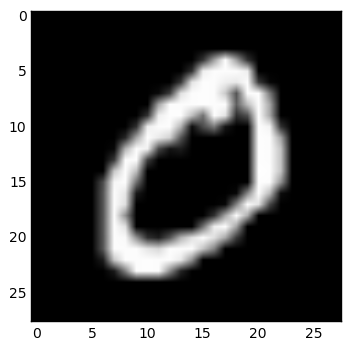

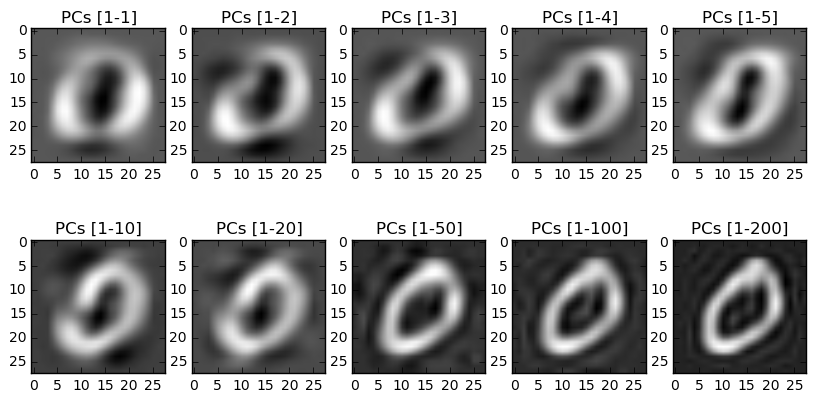

In [103]:
#pick a single point
mypt = mypts[1]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5,10,20,50,100,200]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,:myPCs[i]] #grab PCs 1-myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PCs [1-%d]' %(myPCs[i]))
    

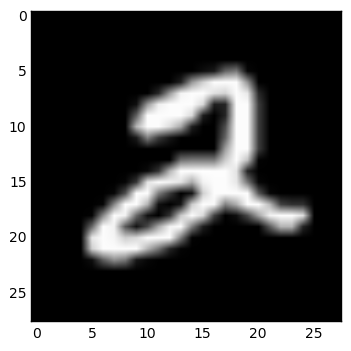

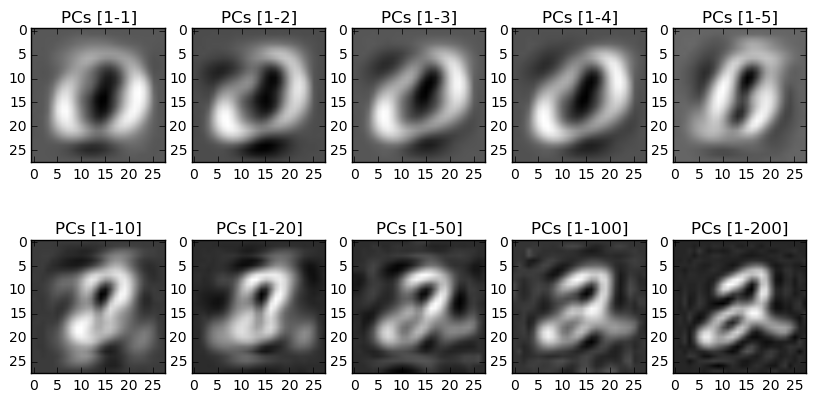

In [104]:
#pick a single point
mypt = mypts[5]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5,10,20,50,100,200]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,:myPCs[i]] #grab PCs 1-myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PCs [1-%d]' %(myPCs[i]))

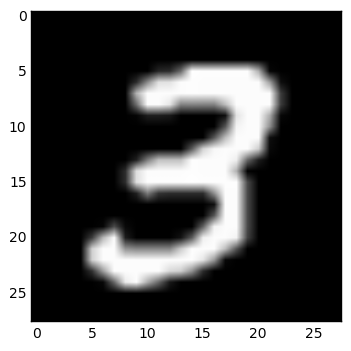

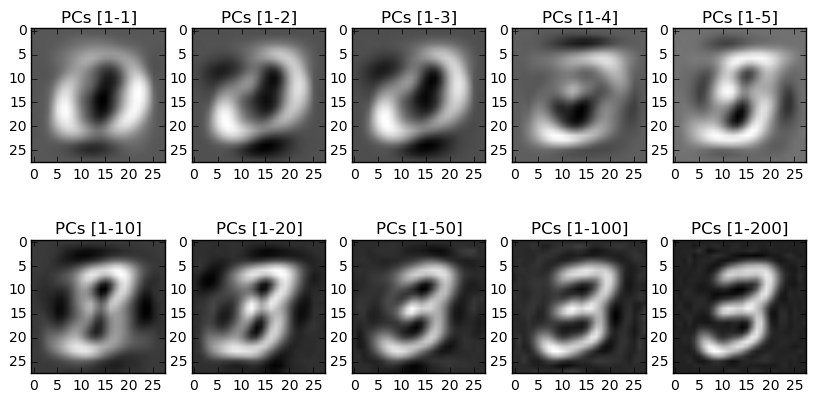

In [105]:
#pick a single point
mypt = mypts[7]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5,10,20,50,100,200]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,:myPCs[i]] #grab PCs 1-myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PCs [1-%d]' %(myPCs[i]))

It looks like one could start making out the digit using the first ~20-50 components. After ~100 components, the representation of the image is quite accurate!
It looks like 0 is the easiest digit to explain with these components. Presumably this is becasue it is the most symmetric digit and is in some sense the basis for all other digits. The other PCs look like they chisel out various parts of the symmetric 0 circle to create the different digits. (Here "basis" was not intended in the mathematical sense of the word, though it does look like the first PC is basically a 0, so maybe it is a mathematical basis after all.)

### Projecting the image onto the first 5 components individually.

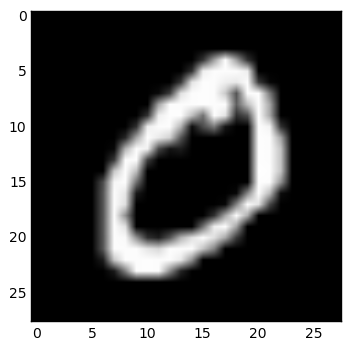

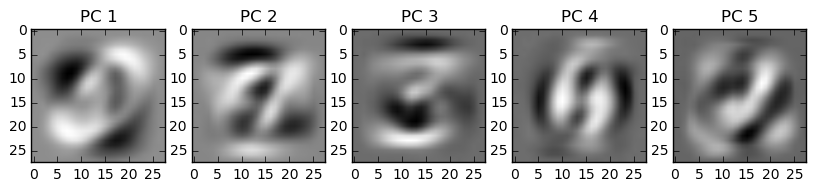

In [106]:
#pick a single point
mypt = mypts[1]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,myPCs[i]] #grab only PC = myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PC %d' %(myPCs[i]))

I think there's some intrepretabiity here. The PCs seem all to contain some features of the outline along with the lack of density either outside the perimeter of the 0 or inside of it. The first component is a diagonal circular shape, with shadows along the x = -y diagnoal. The second PC detracts density at the top and the bottom, the 4th seems to detract it from left and right, etc.

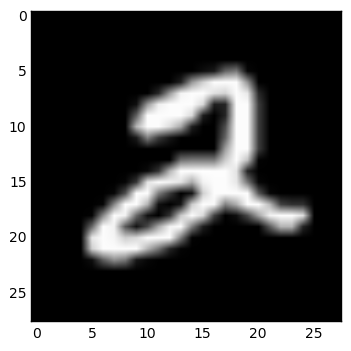

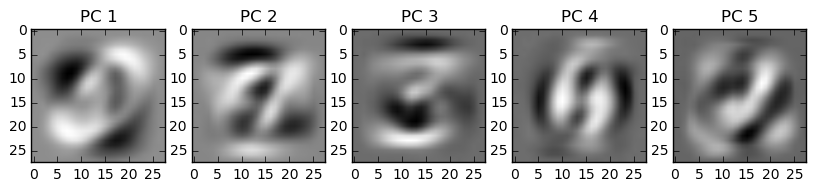

In [107]:
#pick a single point
mypt = mypts[5]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,myPCs[i]] #grab only PC = myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PC %d' %(myPCs[i]))

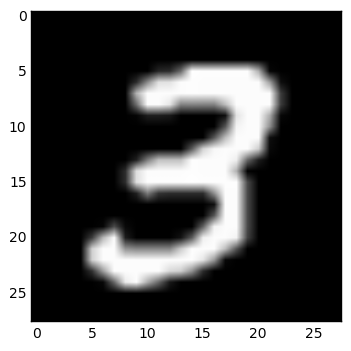

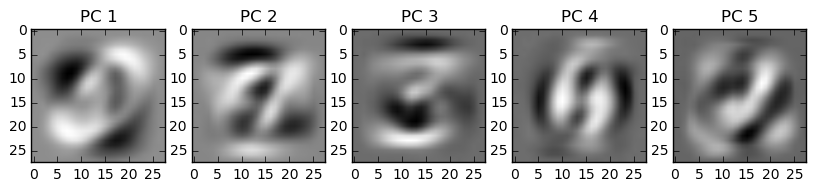

In [108]:
#pick a single point
mypt = mypts[7]

#plot the data point
plt.imshow(mypt.reshape(28,28),cmap='gray')

plt.figure(figsize=(10,5))
#plot projections onto many PCs
myPCs = [1,2,3,4,5]
for i in np.arange(len(myPCs)):
    plt.subplot(2,5,i+1)
    myEvecs = eVecs[:,myPCs[i]] #grab only PC = myPCs[i]
    p1 = np.dot(myEvecs.T,mypt.T)
    p2 = np.dot(p1.T,myEvecs.T)
    plt.imshow(p2.reshape((28,28)),cmap='gray')
    plt.title('PC %d' %(myPCs[i]))

## 1(d): Plot reconstruction error

In [109]:
def pca_error(x,eVec_in):
    p1 = np.dot(eVec_in.T,x)
    p2 = np.dot(p1.T,eVec_in.T)
    return np.sum((x-p2)**2)



In [110]:
ix = [10*(i)+1 for i in np.arange(50)]
myErs = np.zeros(len(ix))
for i in np.arange(1,len(ix)):
    myEvecs = eVecs[:,:ix[i]]
    myErs[i] = all_data_features.map(lambda x: pca_error(x,myEvecs)).reduce(lambda a,b: a+b)

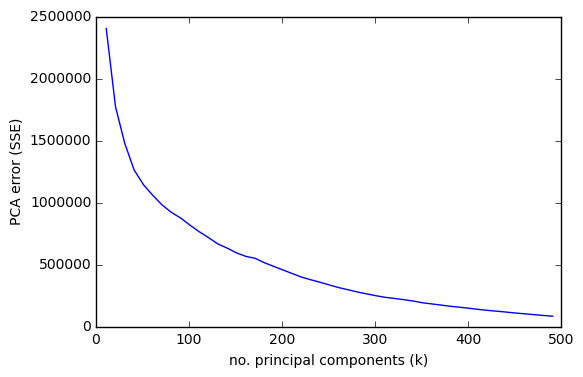

In [111]:
plt.plot(ix[1:],myErs[1:])
plt.xlabel('no. principal components (k)')
plt.ylabel('PCA error (SSE)')

PCA error decreases by a lot for the first ~100 components, then it seems to start slowing down (hitting a sort of an elbow). Of course, if we plotted PCA error for k = no. dimensions of original data, we'd have to se 0 error. 

# Part 2: K means

In [119]:
from pyspark.mllib.clustering import KMeans
subset_features_forKmns = subset.map(lambda x: x[0])
clusters = KMeans.train(subset_features_forKmns, 10, maxIterations=50, initializationMode="random")

In [120]:
#predict which cluster each of the digits in the sample belongs to
predicted_cluster_labels_rdd = clusters.predict(subset_features_forKmns)

In [121]:
#collect predicted cluster labels
predicted_cluster_labels = predicted_cluster_labels_rdd.collect()

In [122]:
#for every cluster label, get the actual majority label
predicted_cluster_labels = np.array(predicted_cluster_labels)
uni_clust=np.unique(predicted_cluster_labels)
true_labels = np.array(subset_labels)

#initialize arrays to store actual vs kmeans predicted labels
maj_label = np.zeros(len(uni_clust))
kmeans_label = np.zeros(len(uni_clust))

for i in uni_clust:
    #get indices of predicted entries belonging to cluster[i]
    ix = (predicted_cluster_labels == uni_clust[i])
    
    #true labels for these indices
    true_lab = true_labels[ix]
    
    #find most common true label using a counter
    cnt_true_lab = Counter(true_lab)
   
    #set this to maj label
    #maj_label[ix] = cnt_true_lab.most_common(1)[0][0] #returns [(entry,cnt_entry)]
    maj_label[i] = cnt_true_lab.most_common(1)[0][0]
    kmeans_label[i] = uni_clust[i]

In [125]:
#make a figure of 20 digits, overlayed with inferred labels
nsb = 20

subset_to_plt = subset_features_forKmns.sample(False,float(40)/float(50000),seed=None)
subset_to_plt_collected = subset_to_plt.collect()

predicted_labels_to_plt_rdd = clusters.predict(subset_to_plt)
predicted_labels_to_plt = predicted_labels_to_plt_rdd.collect()


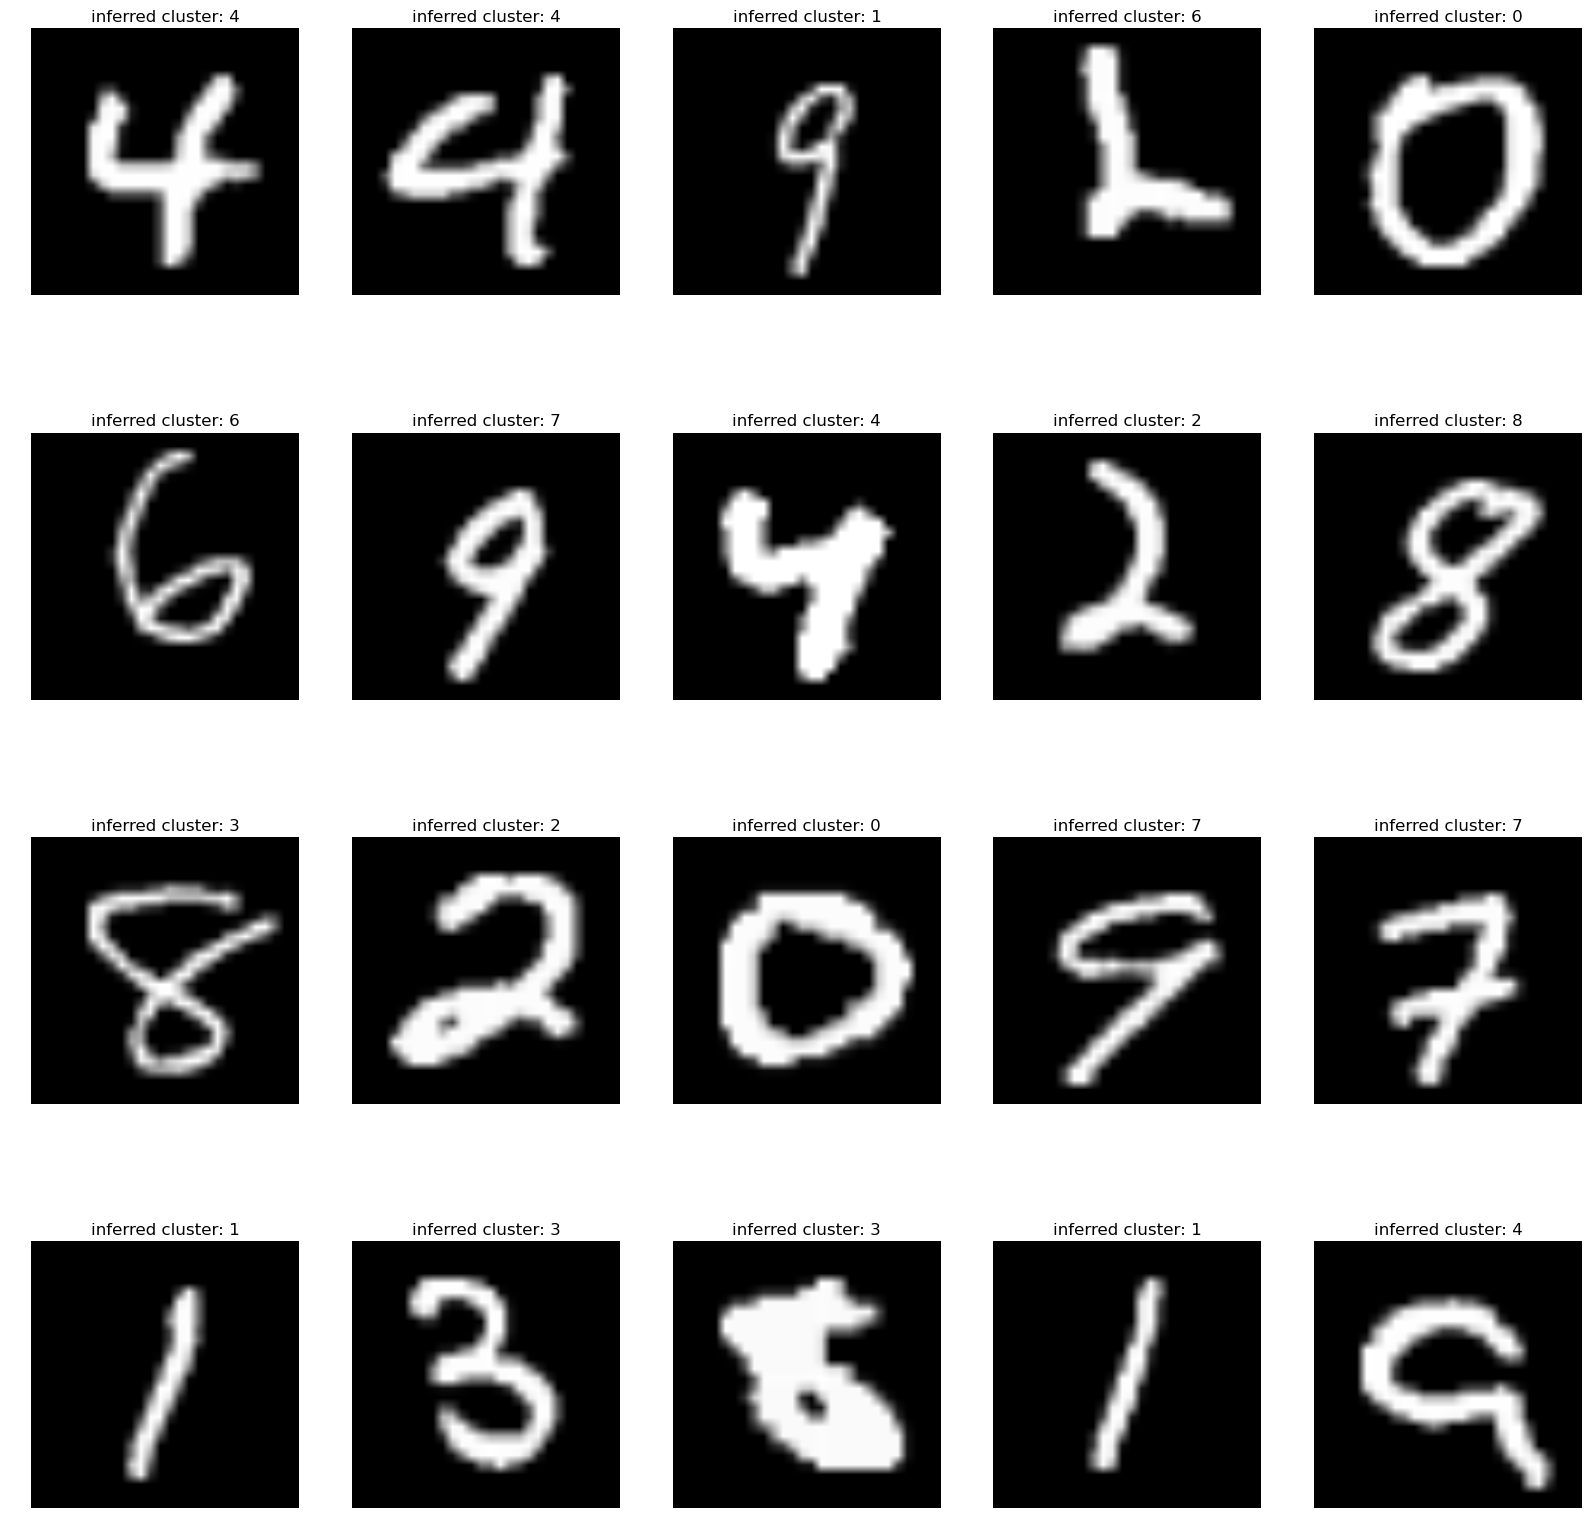

In [126]:
plt.figure(figsize=(20,20))
for j in np.arange(nsb):
    plt.subplot(4,5,j)
    plt.imshow(subset_to_plt_collected[j].reshape((28,28)), cmap='gray')
    this_cluster_id = predicted_labels_to_plt[j]
    this_maj_label = maj_label[this_cluster_id]
    plt.title("inferred cluster: " + str(int(this_maj_label)))
    plt.axis('off')
    

The agreement is pretty good! Not surprisingly, sometimes the algorithm gets confused between similar-looking digits, such as 3's and 8's, for example. Or 1's and 7's. Sometimes 0's and 6's are mixed up too. 

# Part 3: Spectral Decomposition

Spectral clustering uses k-means on top of a low dimensional representation of data. It makes use of the spectrum (eigenvectors) of a particular similarity matrix of the data in order to perform the dimensionality reduction.

### Constucting the L matrix

Construct the similarity matrix A by applying Gaussian kernel to squared distance: $$A_{ij} = exp(−∥x_i − x_j∥2/h),$$
where $x_i, x_j$ are digits. The value of the bandwidth h is crucial for good clustering perfor- mance. You should experiment with different values to get an appropriate scaling.

In [127]:
df = spark.read.json('/project/cmsc25025/mnist/data.json')
all_data = df.rdd.map(lambda x: (np.array(x['features']),int(x[1])))

#data and labels
all_data_features = all_data.map(lambda x: x[0])
all_data_labels = all_data.map(lambda x: x[1])

#define sim matrix
#assume x=(x[0],x[1]), and you want to return
#A(x[0],x[1])
def A_mat(x,h):
    return np.exp(-np.linalg.norm([x[1]-x[0]])**2 / float(h))

#work with a smaller dataset to avoid memory issues
#alternatively, could try strategies as above
sub_data = all_data_features.sample(False, float(300)/float(70000),seed=123).collect()
subN = len(sub_data)
print len(sub_data[0])
print subN

sub_data = spark.sparkContext.parallelize(sub_data)

784
343


In [128]:
#turn into bonafide similarity matrix
sim_mat_A_rdd = sub_data.cartesian(sub_data).map(lambda x: A_mat(x,150.0))
sim_mat_A     = sim_mat_A_rdd.collect()
sim_mat_A = np.array(sim_mat_A).reshape((subN,subN)) #(343,343)

Next, compute the normalized graph Laplacian matrix
$L = I − D^{-1/2}AD^{−1/2}$
where D is the diagonal matrix $D_{ii} = \Sigma_j A_{ij}$.

In [75]:
#print sim_mat_A[342,:]

In [129]:
#identity matrix
id_mat_I = np.identity((subN))

#diagonal matrix
d_mat_D = np.zeros((subN,subN))
for i in np.arange(subN):
    d_mat_D[i,i]=np.sum(sim_mat_A[i,:]**-0.5) #normalize b/c need it for multiplication below
    #print i, d_mat_D[i,i]


In [130]:
#laplacian
lap_mat_L = id_mat_I - np.dot(np.dot(d_mat_D,sim_mat_A),d_mat_D)

#do SVD on laplacian and similarity matrices
lap_mat_eVals, lap_mat_eVecs = np.linalg.eigh(lap_mat_L)
a_mat_eVals, a_mat_eVecs = np.linalg.eigh(sim_mat_A)

#### Spectra of A and L

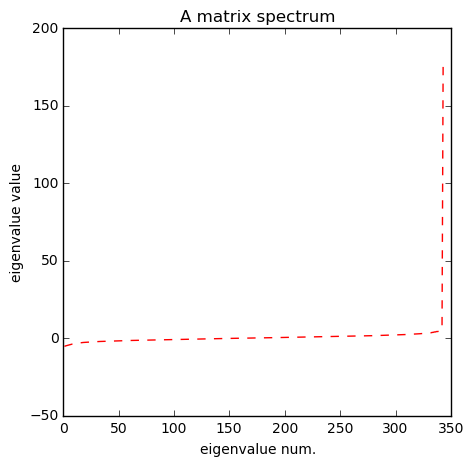

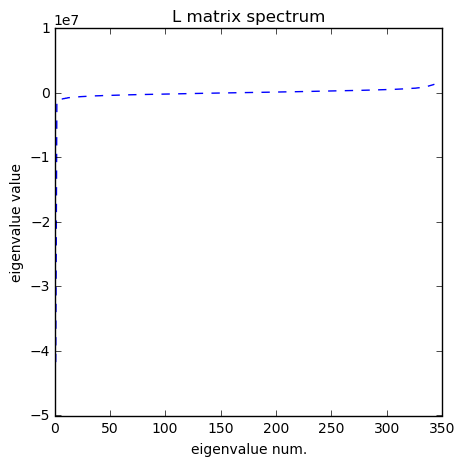

In [131]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(len(a_mat_eVals))+1,a_mat_eVals,'r--')
plt.xlabel('eigenvalue num.')
plt.ylabel('eigenvalue value')
plt.title('A matrix spectrum')

plt.figure(figsize=(5,5))
plt.plot(np.arange(len(lap_mat_eVals))+1,lap_mat_eVals,'b--')
plt.xlabel('eigenvalue num.')
plt.ylabel('eigenvalue value')
plt.title('L matrix spectrum')

#### Last eigenvector

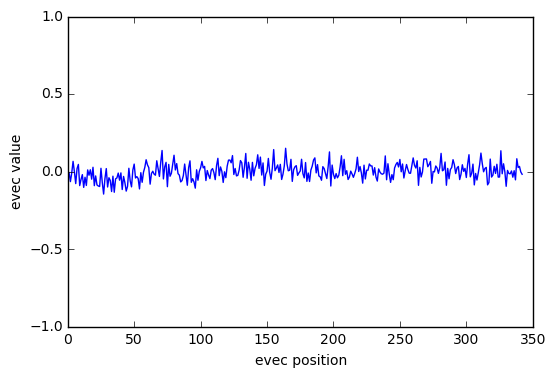

In [71]:
plt.plot(lap_mat_eVecs[:,-1])
plt.ylim([-1,1])
plt.xlabel('evec position')
plt.ylabel('evec value')

Constant eigenvector has the smallest eigenvalue and is flat.

### K-means on clusters

In [78]:
from pyspark.mllib.clustering import KMeans

#pick lowest three evecs of L
digits_in_laplacian = np.array(lap_mat_eVecs[:,0:20]).T
digits_in_laplacian_rdd = spark.sparkContext.parallelize(digits_in_laplacian).map(lambda x: np.array(x))
clusters = KMeans.train(digits_in_laplacian_rdd, 10, maxIterations=50, runs=10, initializationMode="random")

predicted_cluster_labels = clusters.predict(sub_data)

In [87]:
print "I got very confused at this point."
print "I couldn't figure out what we were getting out of clustering the eigenvectors themselves."
print "I also didn't see how we could use this model to predict which clusters our data belonged to."
print "I am probably just being dense, but I couldn't proceed with this problem. Sorry."

I got very confused at this point.
I couldn't figure out what we were getting out of clustering the eigenvectors themselves.
I also didn't see how we could use this model to predict which clusters our data belonged to.
I am probably just being dense, but I couldn't proceed with this problem. Sorry.


# Part 4: Classification

In [132]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

train_data, dev_data, test_data = df.rdd.randomSplit([4, 1, 1])

# Load and parse the data
def parsePoint(x):
    z = LabeledPoint(int(x["label"]),x["features"])
    #print z
    return z
#poop = train.map(parsePoint).take(1)

## 4(a): Multinomial logistic regression

Using the raw features of mnist data, train the model on the training set, evaluate the model on development set, and calculate the error rate.

In [133]:
#train model on training set; use only features (x[0])
model = LogisticRegressionWithLBFGS.train(train_data.map(parsePoint), iterations=100, numClasses=10)

In [134]:
# Evaluate the model on training data
# code to compute MSE from: https://spark.apache.org/docs/2.1.0/mllib-linear-methods.html
valuesAndPreds = train_data.map(parsePoint).map(lambda p: (p.label, model.predict(p.features)))
#only count whether got the fit correct or not [0 or 1 error]
SIGN_MSE = valuesAndPreds \
    .map(lambda (v, p): np.sign((v - p)**2)) \
    .reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Error rate on training data = " + str(SIGN_MSE))

## repeat for dev-t data
valuesAndPreds = dev_data.map(parsePoint).map(lambda p: (p.label, model.predict(p.features)))
#only count whether got the fit correct or not [0 or 1 error]
SIGN_MSE = valuesAndPreds \
    .map(lambda (v, p): np.sign((v - p)**2)) \
    .reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Error rate on devt data = " + str(SIGN_MSE))

Error rate on training data = 0.0583326145088
Error rate on devt data = 0.0827702702703


The next step is to determine how well PCA works in terms of classification. To use PCA for classification, we first represent each data point in terms of its principal components. Then, we train a classifier to predict the class label given those principal components, using logistic regression. To predict the label for a new data point, we use its projection onto the principal eigenvectors.

In [135]:
from pyspark.mllib.feature import PCA 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

train_data, dev_data, test_data = df.rdd.randomSplit([4, 1, 1])
#train_data = df.rdd
features_vec_rdd = train_data.map(lambda x: (x['label'], x['features']))\
                           .map(lambda x: Vectors.dense(x[1]))

## 4(a): PCA + multinomial logistic workflow

In [136]:
from pyspark.mllib.feature import PCA 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

#split data into training, dev-t, testing sets
train_data, dev_data, test_data = df.rdd.randomSplit([4, 1, 1])

# Load and parse PCA'd data
def parsePCAPoint(x):
    z = LabeledPoint(int(x[0]),x[1])
    return z

#perform logistic regression + PCA with k components
def log_pca(myrdd,k):
    #extract features from myrdd
    features_vec_rdd = myrdd.map(lambda x: (x['label'], x['features']))\
                               .map(lambda x: Vectors.dense(x[1]))
    #run k-dim pca
    pca_model = PCA(k).fit(features_vec_rdd)
    
    #project data onto principal vectors
    transformed_features_rdd = pca_model.transform(features_vec_rdd)
    
    #now use this transformed coordinate system in logistic regression
    coll_transformed_features = transformed_features_rdd.collect()
    coll_labels = myrdd.map(lambda x: x['label']).collect()
    
    #add PCA'd vectors + labels to a new RDD
    coll_tuple = zip(coll_labels,coll_transformed_features)
    transformed_labeled_rdd = spark.sparkContext.parallelize(coll_tuple)
    
    #run logistic regression on PCA'd data, fix num. iter and classes
    pca_logistic_model = LogisticRegressionWithLBFGS.\
                                    train(transformed_labeled_rdd.map(parsePCAPoint),\
                                          iterations=50, numClasses=10)
    return pca_model, pca_logistic_model

#test regression+PCA model on rdd
def eval_model(pca_model,pca_logistic_model,myrdd):
    features_vec_rdd = myrdd.map(lambda x: (x['label'], x['features']))\
                            .map(lambda x: Vectors.dense(x[1]))
    #transform myrdd into a lower-d dataset
    transformed_features_rdd = pca_model.transform(features_vec_rdd)

    #now use this transformed coordinate system in logistic regression
    coll_transformed_features = transformed_features_rdd.collect()
    coll_labels = myrdd.map(lambda x: x['label']).collect()
    
    #add PCA'd vectors + labels to a new RDD
    coll_tuple = zip(coll_labels,coll_transformed_features)
    coll_transformed_labeled_rdd = spark.sparkContext.parallelize(coll_tuple)

    #compute (label, predicted_label) for every point in rdd
    valuesAndPreds = coll_transformed_labeled_rdd.map(parsePCAPoint).\
        map(lambda p: (int(p.label), int(pca_logistic_model.predict(p.features))))                    
    
    #compute error rate
    #only count whether got the fit correct or not [0 or 1 error]
    FRAC_WRONG = valuesAndPreds \
            .map(lambda (v, p): np.sign((float(v) - p)**2)) \
            .reduce(lambda x, y: float(x) + y) / valuesAndPreds.count()
    return FRAC_WRONG                       

## 4(b): multinomial logistic regression for different PCA reductions

In [137]:
#run PCA-logistic regression for k=[1,6,11,16,21] principal components
#report test and training error rate
ix = [5*(i)+1 for i in np.arange(5)]
train_err_rate = np.zeros((len(ix)))
test_err_rate = np.zeros((len(ix)))
for k in np.arange(len(ix)):
    pca_model, pca_logistic_model = log_pca(train_data,ix[k])
    train_err_rate[k] = eval_model(pca_model,pca_logistic_model,train_data)
    test_err_rate[k] = eval_model(pca_model,pca_logistic_model,test_data)
    print "train_err_rate: ", train_err_rate[k]
    print "test_err_rate: ", test_err_rate[k]

train_err_rate:  0.810573731626
test_err_rate:  0.813628620102
train_err_rate:  0.273718694771
test_err_rate:  0.279131175468
train_err_rate:  0.199017199017
test_err_rate:  0.206899488927
train_err_rate:  0.148346911505
test_err_rate:  0.155706984668
train_err_rate:  0.125371783267
test_err_rate:  0.130153321976


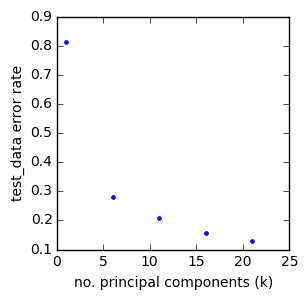

In [140]:
plt.figure(figsize=(3,3))
plt.plot(ix,test_err_rate,'.')
plt.xlabel('no. principal components (k)')
plt.ylabel('test_data error rate')

The error_rate function kinks significantly around ~5-10 principal components. It looks like after 10 components the error rate is about 20%. Going past 20 principal components can reduce the error even further. (See the figures and comments below looking for minimum in the curve for larger k.)

## 4(c): comparison of PCA-logistic vs. logistic-only

In [141]:
# Load and parse the data for logistic only
def parsePoint(x):
    z = LabeledPoint(int(x["label"]),x["features"])
    return z

#logistic-only model
def logistic_only(myrdd):
    #train model on training set; use only features (x[0])
    logistic_model = LogisticRegressionWithLBFGS.train(myrdd.map(parsePoint), iterations=100, numClasses=10)
    return logistic_model

#get error of logistic-only model on your data
def eval_logistic_only(logistic_model,myrdd):
    # Evaluate the model on training data
    # code to compute MSE from: https://spark.apache.org/docs/2.1.0/mllib-linear-methods.html
    valuesAndPreds = myrdd.map(parsePoint).map(lambda p: (p.label, logistic_model.predict(p.features)))
    #only count whether got the fit correct or not [0 or 1 error]
    FRAC_WRONG = valuesAndPreds \
        .map(lambda (v, p): np.sign((v - p)**2)) \
        .reduce(lambda x, y: x + y) / valuesAndPreds.count()
    return FRAC_WRONG


In [142]:
logistic_model = logistic_only(train_data)
train_err_logistic = eval_logistic_only(logistic_model,train_data)
test_err_logistic = eval_logistic_only(logistic_model,test_data)
print 'training error for logistic-only model:', train_err_logistic
print 'test error for logistic-only model:', test_err_logistic

training error for logistic-only model: 0.057976636924
test error for logistic-only model: 0.0885860306644


Pick k that minimizes the error on the development data. Retrain the model using both training and development data. Compute the error rate on testing data. Compare the result to multinomial logistic regression using raw features, and describe your findings.

In [143]:
ix = [3*(i)+1 for i in np.arange(3,14)]
train_err_rate = np.zeros((len(ix)))
dev_err_rate = np.zeros((len(ix)))
for k in np.arange(len(ix)):
    pca_model, pca_logistic_model = log_pca(train_data,ix[k])
    train_err_rate[k] = eval_model(pca_model,pca_logistic_model,train_data)
    dev_err_rate[k] = eval_model(pca_model,pca_logistic_model,dev_data)
    print "no. components: ", ix[k]
    print "train_err_rate: ", train_err_rate[k]
    print "dev_err_rate: ", dev_err_rate[k]

no. components:  10
train_err_rate:  0.201301780249
dev_err_rate:  0.200303490137
no. components:  13
train_err_rate:  0.172033277296
dev_err_rate:  0.172736469398
no. components:  16
train_err_rate:  0.148346911505
dev_err_rate:  0.149806103524
no. components:  19
train_err_rate:  0.131837579206
dev_err_rate:  0.131933906592
no. components:  22
train_err_rate:  0.123281175913
dev_err_rate:  0.12274489968
no. components:  25
train_err_rate:  0.115048062416
dev_err_rate:  0.115326251897
no. components:  28
train_err_rate:  0.112655717919
dev_err_rate:  0.11271286461
no. components:  31
train_err_rate:  0.109940083624
dev_err_rate:  0.111195413927
no. components:  34
train_err_rate:  0.103194103194
dev_err_rate:  0.102512223908
no. components:  37
train_err_rate:  0.100349152981
dev_err_rate:  0.100488956331
no. components:  40
train_err_rate:  0.099077546446
dev_err_rate:  0.0970325408869


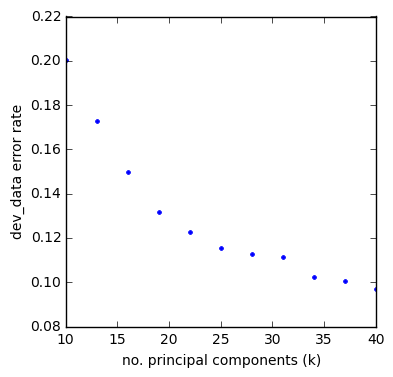

In [144]:
#Looks like dev-error doesn't plateau for even k=40, try larger k below
plt.figure(figsize=(4,4))
plt.plot(ix,dev_err_rate,'.')
plt.xlabel('no. principal components (k)')
plt.ylabel('dev_data error rate')

In [145]:
#saw that dev_error for k=100 --> 0.078, k=200 --> 0.0797, for k=300 --> 0.083, k=400 --> crashes
#sampled more finely:
# k=50 --> 0.092, k=100 --> 0.082, k=150 --> 0.0807, k=200 --> 0.0812
# decided  that best error is at k=150
ix = [50*(i)+1 for i in np.arange(1,5)]
train_err_rate = np.zeros((len(ix)))
dev_err_rate = np.zeros((len(ix)))
for k in np.arange(len(ix)):
    pca_model, pca_logistic_model = log_pca(train_data,ix[k])
    train_err_rate[k] = eval_model(pca_model,pca_logistic_model,train_data)
    dev_err_rate[k] = eval_model(pca_model,pca_logistic_model,dev_data)
    print "no. components: ", ix[k]
    print "train_err_rate: ", train_err_rate[k]
    print "dev_err_rate: ", dev_err_rate[k]

no. components:  51
train_err_rate:  0.0923531186689
dev_err_rate:  0.0904569212612
no. components:  101
train_err_rate:  0.0794646320962
dev_err_rate:  0.0801719777441
no. components:  151
train_err_rate:  0.0746368377947
dev_err_rate:  0.0781487101669
no. components:  201
train_err_rate:  0.0714470451313
dev_err_rate:  0.0767998651155


In [146]:
#merge train with dev data
train_and_dev_data = train_data.union(dev_data)

#re-train PCA-logistic model on this set
pca_model, pca_logistic_model = log_pca(train_and_dev_data,150)

#test this new model on test_data
test_err_rate = eval_model(pca_model, pca_logistic_model, test_data)
print "test_err_rate on for PCA-logistic model (k=150): ", test_err_rate

#compare with logistic model trained on train_and_dev_data
logistic_model = logistic_only(train_and_dev_data)
test_err_logistic = eval_logistic_only(logistic_model,test_data)
print "test_err_rate for logistic-only model: ", test_err_logistic

test_err_rate on for PCA-logistic model (k=150):  0.083730834753
test_err_rate for logistic-only model:  0.0827086882453


It looks like for a large number of principal components (k=150), the dimensionality deduction+logistic approach provides nearly the same accuracy on test data as the logistic regression on raw data. Though 150 dimensions may seem high, it's still only a fraction of the dimensionality of the 784-bit image (~5x reduction), a significant reduction in complexity for the following logistic regression step. In practice, however, if super high accuracy is not required, it would be much cheaper to use a huge dimensionality reduction (k~10) with the logistic approach to attain ~>80% accuracy.